In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import shutil
from tqdm import tqdm
import math

In [2]:
# http://ai.stanford.edu.ezproxy2.utwente.nl/~jkrause/cars/car_dataset.html

In [3]:
def load_dataset(path, split=None):
    training_labels = scipy.io.loadmat(path)
    res = [np.array([bbox_x1, bbox_y1, bbox_x2, bbox_y2, label, file_name], dtype='object').reshape(-1) 
           for bbox_x1, bbox_y1, bbox_x2, bbox_y2, label, file_name in training_labels['annotations'][0]]
    return np.asarray(res) # Returns bbox_x1, bbox_y1, bbox_x2, bbox_y2, label, file_name

def load_labels(path):
    mat = scipy.io.loadmat(path)
    class_names = [l[0] for l in mat['class_names'][0,:]]
    # How stupid that the class indices start with 1... 
    # Replace the '/' for when creating structure 
    label_map = {idx+1: name.replace('/', '_') for idx, name in enumerate(class_names)}
    return label_map # {class_index: label}

def lookup_class_idx_by_file_name(dataset, file_name):
    idx = np.where(dataset[:, 5]==file_name) # Do lookup by file_name
    class_idx = dataset[idx, 4]
    return class_idx[0,0]

def mkdir_if_not_exists(dirpath):
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)

### Paths
To use this notebooks correctly adjust the paths below to your corresponding directories:

from `http://ai.stanford.edu.ezproxy2.utwente.nl/~jkrause/cars/car_dataset.html` download the:
- <b>cars_train</b> (training images)
- <b>cars_test</b> (testing images)
- <b>annotations</b> (devkit + test annotations, the test annotation can be downloaded from the 'update' paragraph)

File structure you need to create must look like: 
```
data
│   
└───StanfordCars
    │
    └───cars_train
    │    +   [training_images...]
    └───cars_test
    │    +   [testing_images...]
    └───annotations
         +  cars_train_annos.mat
         +  cars_test_annos_withlabels.mat
         +  cars_meta.mat
```

In [4]:
global_path = '../data/StanfordCars'
training_imgs_path = global_path+'/cars_train'
testing_imgs_path = global_path+'/cars_test'

training_dataset = load_dataset(global_path+'/annotations/cars_train_annos.mat')
testing_dataset = load_dataset(global_path+'/annotations/cars_test_annos_withlabels.mat')
label_map= load_labels(global_path+'/annotations/cars_meta.mat')

In [5]:
# Create structure for loading into PyTorch Dataset model
folder_name = 'pytorch_structured_dataset'
folder_path = os.path.join(global_path, folder_name)


mkdir_if_not_exists(folder_path)
for subfolder_name in ['train', 'test', 'val']:
    subfolder_path = os.path.join(folder_path, subfolder_name)
    mkdir_if_not_exists(subfolder_path)
    for label in label_map.values():
        mkdir_if_not_exists(os.path.join(subfolder_path, label))

In [6]:
# Testing dataset needs to be split into validation and testing (split in half)


In [8]:
# Put all the training images into every directory
val_imgs_path, test_imgs_path = np.split(np.asarray(os.listdir(testing_imgs_path))[:-1], 2)
imgs_path = {
    'train': os.listdir(training_imgs_path),
    'val': val_imgs_path,
    'test': test_imgs_path
}

dataset = {
    'train': training_dataset,
    'val': [],
    'test': testing_dataset
}

for subfolder_name, relative_path in [('train', training_imgs_path),
                                      ('val', testing_imgs_path),
                                      ('test', testing_imgs_path)]:
    for img_path in tqdm(imgs_path[subfolder_name]):
        # print(training_imgs_path+'/'+img_path)
        # Get class by looking up file_name
        if subfolder_name in ['val', 'test']:
            img_class_idx = lookup_class_idx_by_file_name(dataset['test'], img_path)
        else:
            img_class_idx = lookup_class_idx_by_file_name(dataset[subfolder_name], img_path)
        img_class_label = label_map[img_class_idx]

        src = os.path.join(relative_path, img_path)
        dst = os.path.join(global_path, folder_name, subfolder_name, img_class_label, img_path)
        # dst = global_path+'/'+folder_name+'/train/'+img_class_label+'/'+img_path
        shutil.copyfile(src, dst)


100%|██████████| 4020/4020 [00:02<00:00, 1454.94it/s]


In [95]:
# Create seperate directory for testing images
# folder_name = 'pytorch_structured_dataset'
# folder_path = os.path.join(global_path, folder_name, 'test')

# mkdir_if_not_exists(folder_path)


100%|██████████| 8041/8041 [00:05<00:00, 1423.82it/s]


In [96]:
def bar_plot_classes(dataset, classes):
    print("Length:", len(dataset))
    plt.figure(figsize=(16, 7), dpi=90)
    plt.xticks(np.arange(0, len(classes)+1, 5), rotation=45, ha="right")
    plt.xlabel('classes', fontsize=8, labelpad=4)

    plt.bar(np.arange(0, len(classes), 1), counts, width=0.6, align='center')   

Length: 16185


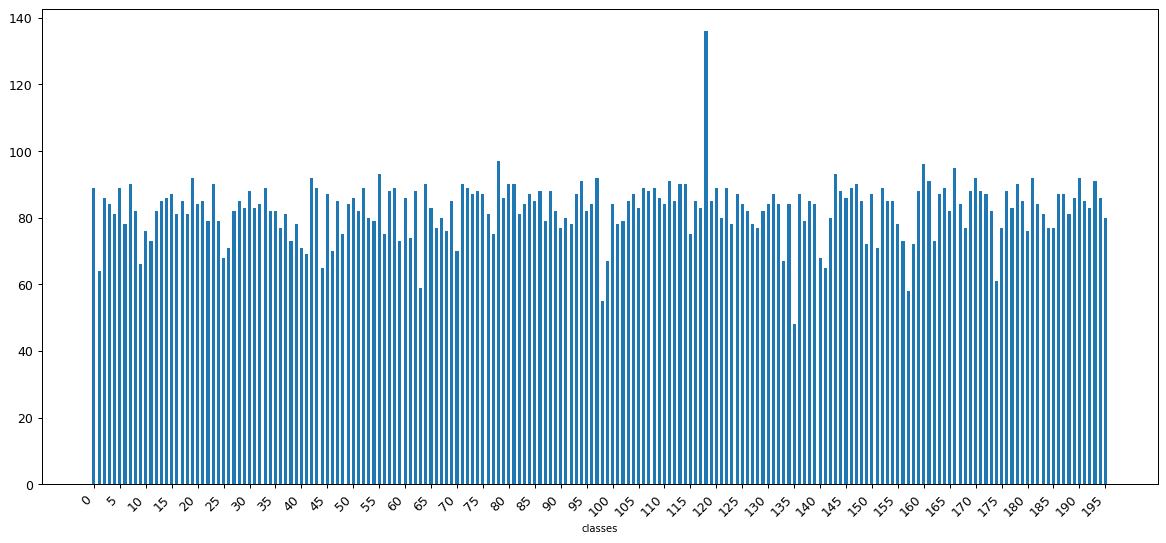

In [97]:
# Distributions of the classes
total_dataset_classes = np.append(testing_dataset[:, 4], training_dataset[:, 4])
unique, counts = np.unique(total_dataset_classes, return_counts=True)
classes = [label_map.get(class_) for class_ in unique]

bar_plot_classes(total_dataset_classes, classes)

In [100]:
testing_dataset_length = math.floor(testing_dataset.shape[0]/2)
validation_dataset_length = math.ceil(testing_dataset.shape[0]/2)

print("Sample count:\n\
training:   {} \n\
testing:    {} \n\
validation: {} \n\
".format(training_dataset.shape[0], testing_dataset_length, validation_dataset_length))

Sample count:
training:   8144 
testing:    4020 
validation: 4021 



In [ ]:
len(training_dataset[:,4]), len(testing_dataset[:,4])

In [ ]:
np.arange(0, len(classes), 1)

In [136]:

    
# for arr in np.split():
#     print(len(arr))

1 ['00076.jpg', '00457.jpg', '00684.jpg', '01117.jpg', '01167.jpg', '01199.jpg', '01226.jpg', '01461.jpg', '01518.jpg', '01538.jpg', '01802.jpg', '01887.jpg', '01918.jpg', '01946.jpg', '02017.jpg', '02205.jpg', '02217.jpg', '02267.jpg', '02547.jpg', '02602.jpg', '02665.jpg', '02835.jpg', '03073.jpg', '03094.jpg', '03193.jpg', '03246.jpg', '03585.jpg', '03640.jpg', '03876.jpg', '03904.jpg', '04088.jpg', '04117.jpg', '04768.jpg', '05023.jpg', '05275.jpg', '05605.jpg', '05888.jpg', '06051.jpg', '07258.jpg', '07393.jpg', '07530.jpg', '07917.jpg', '07948.jpg', '08035.jpg']


In [137]:
val_dataset

{1: array(['03073.jpg', '03094.jpg', '03193.jpg', '03246.jpg', '03585.jpg',
        '03640.jpg', '03876.jpg', '03904.jpg', '04088.jpg', '04117.jpg',
        '04768.jpg', '05023.jpg', '05275.jpg', '05605.jpg', '05888.jpg',
        '06051.jpg', '07258.jpg', '07393.jpg', '07530.jpg', '07917.jpg',
        '07948.jpg', '08035.jpg'], dtype='<U9'),
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: []

In [167]:
testing_dataset

array([[30, 52, 246, 147, 181, '00001.jpg'],
       [100, 19, 576, 203, 103, '00002.jpg'],
       [51, 105, 968, 659, 145, '00003.jpg'],
       ...,
       [33, 27, 602, 252, 17, '08039.jpg'],
       [33, 142, 521, 376, 38, '08040.jpg'],
       [77, 73, 506, 380, 32, '08041.jpg']], dtype=object)